In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from torchsummary import summary as Summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 100
batch_size = 64
lr = 5e-5
img_shape = (3, 32, 32)
n_epochs = 30
n_critic = 5
c = 0.01
l = 10

print(device)

cuda


In [3]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torch.utils.data import DataLoader
import numpy as np
from scipy.linalg import sqrtm

# Load two separate models for efficiency
# Model for features (FID)
inception_fid = inception_v3(pretrained=True, transform_input=False)
inception_fid.fc = torch.nn.Identity()  # Remove final classification layer
inception_fid.aux_logits = False
inception_fid.eval()

# Model for predictions (IS)
inception_is = inception_v3(pretrained=True, transform_input=False)
inception_is.aux_logits = False
inception_is.eval()

if torch.cuda.is_available():
    inception_fid = inception_fid.cuda()
    inception_is = inception_is.cuda()

def preprocess_images(images):
    """Preprocess images for Inception-v3"""
    # Ensure images are in [0, 1] range
    if images.min() >= -1.0 and images.max() <= 1.0:
        # Input is in [-1, 1] range (GAN output)
        images = (images + 1.0) / 2.0
    elif images.max() > 1.0:
        # Input is in [0, 255] range
        images = images / 255.0
    else:
        # Already in [0, 1] range
        pass

    # Clamp to [0, 1]
    images = torch.clamp(images, 0.0, 1.0)

    # Resize to 299x299
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)

    # ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

    if images.is_cuda:
        mean = mean.cuda()
        std = std.cuda()

    images = (images - mean) / std
    return images

def get_features(images, model):
    """Extract 2048-dim features from Inception-v3 for FID calculation"""
    model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            images = images.cuda()

        # Preprocess images
        images = preprocess_images(images)

        # Forward pass - model.fc is Identity, so this gives us 2048-dim features
        features = model(images)

        # Ensure features are 2D (batch_size, 2048)
        if len(features.shape) == 4:
            features = F.adaptive_avg_pool2d(features, (1, 1))
            features = torch.flatten(features, 1)

    return features.cpu()

def get_predictions(images, model):
    """Extract softmax predictions from Inception-v3 for IS calculation"""
    model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            images = images.cuda()

        # Preprocess images
        images = preprocess_images(images)

        # Forward pass - model.fc is intact, so this gives us logits
        logits = model(images)
        preds = F.softmax(logits, dim=1)

    return preds.cpu()

def calculate_stats(features):
    """Calculate mean and covariance matrix of features"""
    features = features.numpy().astype(np.float64)  # Use float64 for numerical stability
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Calculate FID score between two sets of features"""
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    # Ensure matrices are symmetric (numerical stability)
    sigma1 = (sigma1 + sigma1.T) / 2
    sigma2 = (sigma2 + sigma2.T) / 2

    # Add small epsilon to diagonal for numerical stability
    sigma1 += eps * np.eye(sigma1.shape[0])
    sigma2 += eps * np.eye(sigma2.shape[0])

    diff = mu1 - mu2

    # Calculate sqrt of product of covariance matrices
    try:
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    except Exception as e:
        print(f"Error in sqrtm: {e}")
        # Fallback: add more regularization
        sigma1 += eps * 10 * np.eye(sigma1.shape[0])
        sigma2 += eps * 10 * np.eye(sigma2.shape[0])
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)

    # Handle numerical errors in sqrtm
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.absolute(covmean.imag))
            raise ValueError(f"Imaginary component {m}")
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

def compute_inception_score(preds, splits=10):
    """Compute Inception Score from predictions"""
    N = preds.size(0)

    # Ensure we have enough samples for splits
    if N < splits:
        splits = N

    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]

        # Skip empty splits
        if part.size(0) == 0:
            continue

        py = torch.mean(part, dim=0)
        scores = part * (torch.log(part + 1e-8) - torch.log(py + 1e-8))
        kl_div = scores.sum(dim=1).mean()
        split_scores.append(torch.exp(kl_div))

    if len(split_scores) == 0:
        return torch.tensor(1.0), torch.tensor(0.0)

    return torch.mean(torch.tensor(split_scores)), torch.std(torch.tensor(split_scores))

def compute_fid_score(real_images, fake_images, batch_size=64):
    """Compute FID score between real and fake images"""
    # Create data loaders
    real_loader = DataLoader(real_images, batch_size=batch_size, shuffle=False)
    fake_loader = DataLoader(fake_images, batch_size=batch_size, shuffle=False)

    # Process real images
    real_features = []
    for batch in real_loader:
        features = get_features(batch, inception_fid)
        real_features.append(features)
    real_features = torch.cat(real_features, dim=0)

    # Process fake images
    fake_features = []
    for batch in fake_loader:
        features = get_features(batch, inception_fid)
        fake_features.append(features)
    fake_features = torch.cat(fake_features, dim=0)

    # Calculate statistics
    mu_real, sigma_real = calculate_stats(real_features)
    mu_fake, sigma_fake = calculate_stats(fake_features)

    # Calculate FID
    fid_score = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
    return fid_score

def compute_is_score(fake_images, batch_size=64):
    """Compute Inception Score for fake images"""
    fake_loader = DataLoader(fake_images, batch_size=batch_size, shuffle=False)

    # Process fake images
    fake_preds = []
    for batch in fake_loader:
        preds = get_predictions(batch, inception_is)
        fake_preds.append(preds)
    fake_preds = torch.cat(fake_preds, dim=0)

    # Calculate IS
    is_mean, is_std = compute_inception_score(fake_preds)
    return is_mean.item(), is_std.item()

def compute_fid_is(real_images, fake_images, batch_size=64):
    """Compute both FID and IS scores"""
    fid_score = compute_fid_score(real_images, fake_images, batch_size)
    is_mean, is_std = compute_is_score(fake_images, batch_size)
    return fid_score, is_mean, is_std

def evaluate_metrics(generator, dataloader, sample_size, batch_size_fid, latent_dim, device):
    """Evaluate FID and IS scores for a generator"""
    generator.eval()

    # Generate fake images
    fake_images = []
    with torch.no_grad():
        for j in range(0, sample_size, batch_size_fid):
            current_batch = min(batch_size_fid, sample_size - j)
            z = torch.randn(current_batch, latent_dim).to(device)
            fake_batch = generator(z).cpu()
            fake_images.append(fake_batch)
    fake_images = torch.cat(fake_images, dim=0)

    # Collect real images
    real_images = []
    total_collected = 0
    for imgs, _ in dataloader:
        real_images.append(imgs)
        total_collected += imgs.size(0)
        if total_collected >= sample_size:
            break

    real_images = torch.cat(real_images, dim=0)[:sample_size]

    # Ensure we have the same number of real and fake images
    min_size = min(len(real_images), len(fake_images))
    real_images = real_images[:min_size]
    fake_images = fake_images[:min_size]

    # Compute FID and IS
    fid_score, is_mean, is_std = compute_fid_is(real_images, fake_images)

    generator.train()
    return fid_score, is_mean, is_std

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 198MB/s] 


In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat grayscale across 3 channels
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.54MB/s]


In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

generator = Generator(latent_dim).to(device)
print(Summary(generator, input_size=(latent_dim,), batch_size=batch_size, device="cuda"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [64, 8192]         827,392
              ReLU-2                 [64, 8192]               0
         Unflatten-3            [64, 128, 8, 8]               0
          Upsample-4          [64, 128, 16, 16]               0
            Conv2d-5          [64, 128, 16, 16]         147,584
       BatchNorm2d-6          [64, 128, 16, 16]             256
              ReLU-7          [64, 128, 16, 16]               0
          Upsample-8          [64, 128, 32, 32]               0
            Conv2d-9           [64, 64, 32, 32]          73,792
      BatchNorm2d-10           [64, 64, 32, 32]             128
             ReLU-11           [64, 64, 32, 32]               0
           Conv2d-12            [64, 3, 32, 32]           1,731
             Tanh-13            [64, 3, 32, 32]               0
Total params: 1,050,883
Trainable param

In [6]:
class GroupSort(nn.Module):
    def __init__(self, group_size=2):
        super(GroupSort, self).__init__()
        self.group_size = group_size

    def forward(self, x):
        assert x.shape[1] % self.group_size == 0, "Group size must divide the number of channels"
        B, C = x.shape[:2]
        new_shape = (B, C // self.group_size, self.group_size) + x.shape[2:]
        x = x.view(new_shape)
        x, _ = x.sort(dim=2)
        return x.view(B, C, *x.shape[3:])

In [ ]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False),
            GroupSort(group_size=2),    # Activation is repalced with Groupsort 
            nn.Dropout2d(0.2),
            # 64 x 16 x 16

            nn.Conv2d(128,256 , kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([256, 8, 8]),
            GroupSort(group_size=4),    # Activation is repalced with Groupsort 
            nn.Dropout2d(0.2),
            # 128 x 8 x 8

            nn.Conv2d(256,512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([512,4,4]),
            GroupSort(group_size=8),    # Activation is repalced with Groupsort 
            nn.Dropout2d(0.2),
            # 256 x 4 x 4

            # Global average pooling instead of another conv layer
            nn.AdaptiveAvgPool2d(1),  # 256 x 1 x 1
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.model(x)

critic = Critic().to(device)
print(Summary(critic, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]           6,144
         GroupSort-2          [-1, 128, 16, 16]               0
         Dropout2d-3          [-1, 128, 16, 16]               0
            Conv2d-4            [-1, 256, 8, 8]         524,288
         LayerNorm-5            [-1, 256, 8, 8]          32,768
         GroupSort-6            [-1, 256, 8, 8]               0
         Dropout2d-7            [-1, 256, 8, 8]               0
            Conv2d-8            [-1, 512, 4, 4]       2,097,152
         LayerNorm-9            [-1, 512, 4, 4]          16,384
        GroupSort-10            [-1, 512, 4, 4]               0
        Dropout2d-11            [-1, 512, 4, 4]               0
AdaptiveAvgPool2d-12            [-1, 512, 1, 1]               0
          Flatten-13                  [-1, 512]               0
           Linear-14                   

In [8]:
def show_imgs(real_imgs, gen_imgs, label=True , n=10):
    """Display real and generated images side by side"""
    n = min(n, len(real_imgs), len(gen_imgs))  # Ensure we don't exceed available images

    real = real_imgs[:n].cpu().detach()
    fake = gen_imgs[:n].cpu().detach()

    # Rescale from [-1, 1] to [0, 1]
    real = (real + 1) / 2
    fake = (fake + 1) / 2

    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))

    # Handle case where n=1 (axes won't be 2D)
    if n == 1:
        axes = axes.reshape(2, 1)

    for i in range(n):
        # Real images on top row
        real_img = real[i].permute(1, 2, 0).numpy()
        axes[0, i].imshow(real_img, vmin=0, vmax=1)
        axes[0, i].axis("off")
        if i == 0:
          if label:
            axes[0, i].set_title("Real Images")
          else :
            axes[0, i].set_title("Generated Images")
        # Fake images on bottom row
        fake_img = fake[i].permute(1, 2, 0).numpy()
        axes[1, i].imshow(fake_img, vmin=0, vmax=1)
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Generated Images")

    plt.tight_layout()
    plt.show()

In [9]:
def gradient_penalty(critic, real_samples, fake_samples, device):
    batch_size = real_samples.size(0)
    
    # Random interpolation coefficients (no grad needed)
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)
    
    # Interpolate samples
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    # Forward pass
    d_interpolated = critic(interpolated)
    
    # Compute gradients
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Calculate penalty (L2 norm - 1)^2
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)  # More stable than manual sqrt
    penalty = torch.mean((gradient_norm - 1) ** 2)
    
    return penalty

In [10]:
def train_WGAN_CP(generator, critic, optimizer_g, optimizer_c, dataloader, device, latent_dim, n_critic , c , n_epochs , fid_0 , is_0 ):
    os.makedirs("images_WGAN", exist_ok=True)

    g_losses = []
    c_losses = []
    fid_scores = []
    is_scores = []
    fid_scores.append(fid_0)  # Adding the fid value of noise genertaed by the generator before Training
    is_scores.append(is_0)

    for epoch in range(1 , n_epochs+1):
        g_loss_epoch = 0.0  # Intialised the loss variables
        c_loss_epoch = 0.0
        batches = 0

        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batches += 1
            c_loss_n = 0.0
            b_size = imgs.size(0)  # to track the current batch size

            for _ in range(n_critic):
                optimizer_c.zero_grad()

                z = torch.randn(b_size, latent_dim).to(device)
                fake_imgs = generator(z).detach()

                real_validity = critic(real_imgs)
                fake_validity = critic(fake_imgs)

                loss_c = - (torch.mean(real_validity) - torch.mean(fake_validity))   # loss of Critic = max ( E(D(x)) - E(G(z)) )
                c_loss_n += loss_c.item()                                            # maximising the loss = minimising the the -ve of loss as optimizers are used to reduce the loss values
                loss_c.backward()
                optimizer_c.step()

                for p in critic.parameters():           # Weight Clipping
                    p.data.clamp_(-c, c)

            c_loss_epoch += (c_loss_n / n_critic)   # taking Avg of all the losses for n_critic

            optimizer_g.zero_grad()
            z = torch.randn(b_size, latent_dim).to(device)
            gen_imgs = generator(z)
            gen_validity = critic(gen_imgs)
            loss_g = - torch.mean(gen_validity)   # loss of Generator = min( - E(D(G(z))) )
            g_loss_epoch += loss_g.item()         # and we will keep it as it is as optimisers are already doing this
            loss_g.backward()
            optimizer_g.step()

        avg_c_loss = c_loss_epoch / batches
        avg_g_loss = g_loss_epoch / batches

        g_losses.append(avg_g_loss)
        c_losses.append(avg_c_loss)

        fid_score , is_score , _ = evaluate_metrics(generator, dataloader, 5000 , 100 , latent_dim, device)  # Computing the FID and IS in each epoch
        fid_scores.append(fid_score)
        is_scores.append(is_score)

        print(f"[Epoch {epoch}/{n_epochs}] Loss D: {avg_c_loss:.4f}, Loss G: {avg_g_loss:.4f} , FID score : {fid_score:.4f} , IS score : {is_score:.4f}")

        # Printing The Results for every 25th iteration

        if epoch % 10 == 0:
            noise = torch.randn(15,latent_dim).to(device)
            with torch.no_grad():
              gen_images = generator(noise).to(device)
            save_image(gen_images.data[:10], f"images_WGAN/{epoch}.png", nrow=5, normalize=True)
            show_imgs(real_imgs, gen_images, n=10)

    # Plotting The Curves

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(c_losses, label='Critic Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("WGAN Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label='FID Score')
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(is_scores, label='IS Score')
    plt.xlabel("Epoch")
    plt.ylabel("IS")
    plt.title("IS Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return fid_scores , is_scores

In [ ]:
def train_WGAN(generator, critic, optimizer_g, optimizer_c, dataloader, device, latent_dim, n_critic , n_epochs , fid_0 , is_0 ):
    os.makedirs("images_WGAN_no-clip", exist_ok=True)

    g_losses = []
    c_losses = []
    fid_scores = []
    is_scores = []
    fid_scores.append(fid_0)  # Adding the fid value of noise genertaed by the generator before Training
    is_scores.append(is_0)

    for epoch in range(1 , n_epochs+1):
        g_loss_epoch = 0.0  # Intialised the loss variables
        c_loss_epoch = 0.0
        batches = 0

        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batches += 1
            c_loss_n = 0.0
            b_size = imgs.size(0)  # to track the current batch size

            for _ in range(n_critic):
                optimizer_c.zero_grad()

                z = torch.randn(b_size, latent_dim).to(device)
                fake_imgs = generator(z).detach()

                real_validity = critic(real_imgs)
                fake_validity = critic(fake_imgs)

                loss_c = - (torch.mean(real_validity) - torch.mean(fake_validity))   # loss of Critic = max ( E(D(x)) - E(G(z)) )
                c_loss_n += loss_c.item()                                            # maximising the loss = minimising the the -ve of loss as optimizers are used to reduce the loss values
                loss_c.backward()
                optimizer_c.step()

                # for p in critic.parameters():           # Weight Clipping X for testing groupsort 
                #     p.data.clamp_(-c, c)

            c_loss_epoch += (c_loss_n / n_critic)   # taking Avg of all the losses for n_critic

            optimizer_g.zero_grad()
            z = torch.randn(b_size, latent_dim).to(device)
            gen_imgs = generator(z)
            gen_validity = critic(gen_imgs)
            loss_g = - torch.mean(gen_validity)   # loss of Generator = min( - E(D(G(z))) )
            g_loss_epoch += loss_g.item()         # and we will keep it as it is as optimisers are already doing this
            loss_g.backward()
            optimizer_g.step()

        avg_c_loss = c_loss_epoch / batches
        avg_g_loss = g_loss_epoch / batches

        g_losses.append(avg_g_loss)
        c_losses.append(avg_c_loss)

        fid_score , is_score , _ = evaluate_metrics(generator, dataloader, 5000 , 100 , latent_dim, device)  # Computing the FID and IS in each epoch
        fid_scores.append(fid_score)
        is_scores.append(is_score)

        print(f"[Epoch {epoch}/{n_epochs}] Loss D: {avg_c_loss:.4f}, Loss G: {avg_g_loss:.4f} , FID score : {fid_score:.4f} , IS score : {is_score:.4f}")

        # Printing The Results for every 25th iteration

        if epoch % 10 == 0:
            noise = torch.randn(15,latent_dim).to(device)
            with torch.no_grad():
              gen_images = generator(noise).to(device)
            save_image(gen_images.data[:10], f"images_WGAN_no-clip/{epoch}.png", nrow=5, normalize=True)
            show_imgs(real_imgs, gen_images, n=10)

    # Plotting The Curves

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(c_losses, label='Critic Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("WGAN (no Weight Clipping) Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label='FID Score')
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(is_scores, label='IS Score')
    plt.xlabel("Epoch")
    plt.ylabel("IS")
    plt.title("IS Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return fid_scores , is_scores

In [12]:
def train_WGAN_GP(generator, critic, optimizer_g, optimizer_c, dataloader, device, latent_dim, n_critic , l , n_epochs , fid_0 , is_0 ):
    os.makedirs("images_WGAN-GP", exist_ok=True)

    g_losses = []
    c_losses = []
    fid_scores = []
    is_scores = []
    fid_scores.append(fid_0)  # Adding the fid value of noise genertaed by the generator before Training
    is_scores.append(is_0)

    for epoch in range(1 , n_epochs+1):
        g_loss_epoch = 0.0  # Intialised the loss variables
        c_loss_epoch = 0.0
        batches = 0

        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batches += 1
            c_loss_n = 0.0
            b_size = imgs.size(0)  # to track the current batch size

            for _ in range(n_critic):
                optimizer_c.zero_grad()

                z = torch.randn(b_size, latent_dim).to(device)
                fake_imgs = generator(z).detach()

                real_validity = critic(real_imgs)
                fake_validity = critic(fake_imgs)
                
                gp = gradient_penalty(critic , real_imgs, fake_imgs, device)
                loss_c = torch.mean(fake_validity) - torch.mean(real_validity) + l * gp
                c_loss_n += loss_c.item()
                loss_c.backward()
                optimizer_c.step()
                
            c_loss_epoch += (c_loss_n / n_critic)   # taking Avg of all the losses for n_critic

            optimizer_g.zero_grad()
            z = torch.randn(b_size, latent_dim).to(device)
            gen_imgs = generator(z)
            gen_validity = critic(gen_imgs)
            loss_g = - torch.mean(gen_validity)   # loss of Generator = min( - E(D(G(z))) )
            g_loss_epoch += loss_g.item()         # and we will keep it as it is as optimisers are already doing this
            loss_g.backward()
            optimizer_g.step()

        avg_c_loss = c_loss_epoch / batches
        avg_g_loss = g_loss_epoch / batches

        g_losses.append(avg_g_loss)
        c_losses.append(avg_c_loss)

        fid_score , is_score , _ = evaluate_metrics(generator, dataloader, 5000 , 100 , latent_dim, device)  # Computing the FID and IS in each epoch
        fid_scores.append(fid_score)
        is_scores.append(is_score)

        print(f"[Epoch {epoch}/{n_epochs}] Loss D: {avg_c_loss:.4f}, Loss G: {avg_g_loss:.4f} , FID score : {fid_score:.4f} , IS score : {is_score:.4f}")

        # Printing The Results for every 25th iteration

        if epoch % 10 == 0:
            noise = torch.randn(15,latent_dim).to(device)
            with torch.no_grad():
              gen_images = generator(noise).to(device)
            save_image(gen_images.data[:10], f"images_WGAN-GP/{epoch}.png", nrow=5, normalize=True)
            show_imgs(real_imgs, gen_images, n=10)

    # Plotting The Curves

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(c_losses, label='Critic Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("WGAN_GP Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label='FID Score')
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(is_scores, label='Inception Score')
    plt.xlabel("Epoch")
    plt.ylabel("IS")
    plt.title("IS Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return fid_scores , is_scores

In [20]:
def train_vanillaGAN(generator, critic, optimizer_g, optimizer_c, dataloader, device, latent_dim, n_epochs , fid_0 , is_0):
    bce = torch.nn.BCELoss()
    Sigmoid = torch.nn.Sigmoid()
    os.makedirs("images_VanillaGAN", exist_ok=True)

    g_losses = []
    c_losses = []
    fid_scores = []
    is_scores = []
    fid_scores.append(fid_0)  
    is_scores.append(is_0)

    for epoch in range(1 , n_epochs+1):
        g_loss_epoch = 0.0
        c_loss_epoch = 0.0
        batches = 0

        for i, (imgs, _) in enumerate(dataloader):

            real_imgs = imgs.to(device)
            b_size = imgs.size(0)
            batches += 1

            optimizer_c.zero_grad()

            # Real images should get high probability (close to 1)
            real_output = Sigmoid(critic(real_imgs))
            real_loss = -torch.mean(torch.log(real_output + 1e-8))  # -log(D(x))

            # Fake images should get low probability (close to 0)
            z = torch.randn(b_size, latent_dim).to(device)
            fake_imgs = generator(z).detach()
            fake_output = Sigmoid(critic(fake_imgs))
            fake_loss = -torch.mean(torch.log(1 - fake_output + 1e-8))  # -log(1-D(G(z)))

            # Total discriminator loss (we minimize this, which maximizes the original objective)
            loss_c = real_loss + fake_loss
            c_loss_epoch += loss_c.item()
            loss_c.backward()
            optimizer_c.step()

            optimizer_g.zero_grad()
            z = torch.randn(b_size, latent_dim).to(device)
            gen_imgs = generator(z)
            gen_output = Sigmoid(critic(gen_imgs))

            # Non-saturating loss: minimize -log(D(G(z)))
            loss_g = -torch.mean(torch.log(gen_output + 1e-8))
            g_loss_epoch += loss_g.item()
            loss_g.backward()
            optimizer_g.step()

        avg_c_loss = c_loss_epoch / batches
        avg_g_loss = g_loss_epoch / batches

        c_losses.append(avg_c_loss)
        g_losses.append(avg_g_loss)

        fid_score , is_score , _ = evaluate_metrics(generator, dataloader, 5000 , 100 , latent_dim, device)  # Computing the FID and IS in each epoch
        fid_scores.append(fid_score)
        is_scores.append(is_score)

        print(f"[Epoch {epoch}/{n_epochs}] Loss D: {avg_c_loss:.4f}, Loss G: {avg_g_loss:.4f} , FID score : {fid_score:.4f} , Inception score : {is_score:.4f}")
        if epoch % 10 == 0:
            noise = torch.randn(15,latent_dim).to(device)
            with torch.no_grad():
              gen_images = generator(noise).to(device)
            save_image(gen_images.data[:10], f"images_VanillaGAN/{epoch}.png", nrow=5, normalize=True)
            show_imgs(real_imgs, gen_images, n=10)

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(c_losses, label='Critic Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("vanilla-GAN Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label='FID Score')
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(is_scores, label='Inception Score')
    plt.xlabel("Epoch")
    plt.ylabel("IS")
    plt.title("IS Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return fid_scores , is_scores

Before Training...


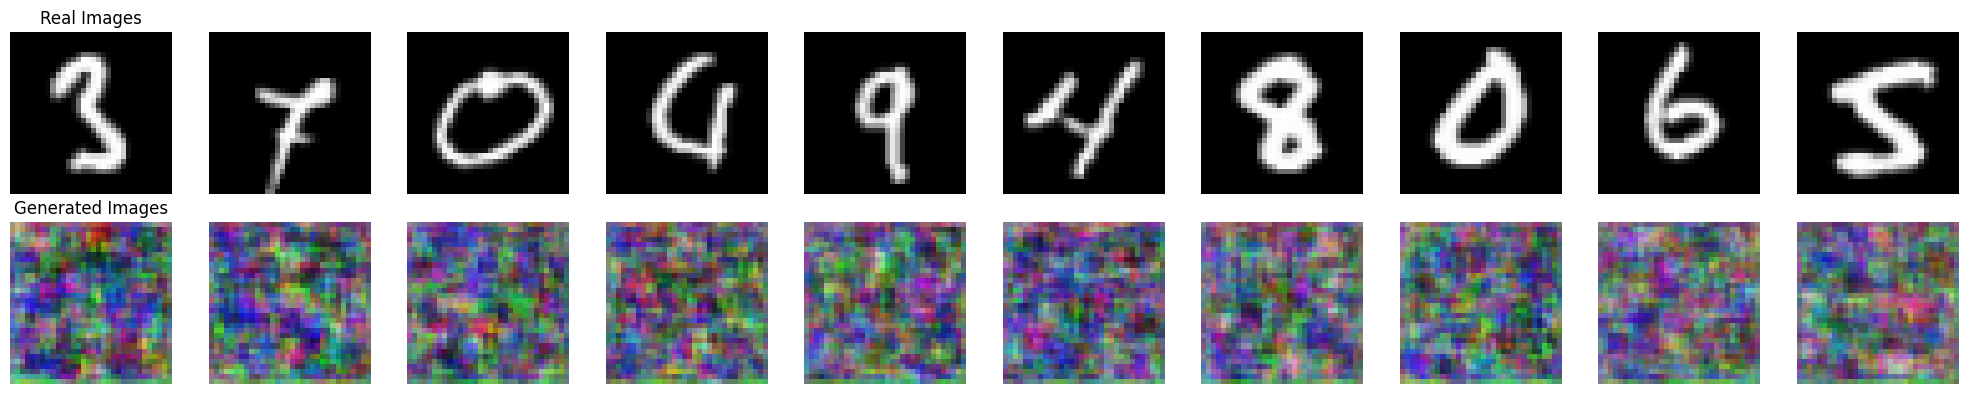

 FID : 392.0276604780746 , IS : 1.069235920906067
Training started...
[Epoch 1/30] Loss D: -0.0538, Loss G: 0.0384 , FID score : 131.5666 , IS score : 2.0477
[Epoch 2/30] Loss D: -0.0742, Loss G: 0.0484 , FID score : 108.8041 , IS score : 2.0866
[Epoch 3/30] Loss D: -0.0759, Loss G: 0.0496 , FID score : 95.8555 , IS score : 2.0935
[Epoch 4/30] Loss D: -0.0765, Loss G: 0.0493 , FID score : 82.5192 , IS score : 2.0943
[Epoch 5/30] Loss D: -0.0760, Loss G: 0.0489 , FID score : 84.7882 , IS score : 2.0829
[Epoch 6/30] Loss D: -0.0752, Loss G: 0.0485 , FID score : 75.4943 , IS score : 2.1182
[Epoch 7/30] Loss D: -0.0738, Loss G: 0.0475 , FID score : 73.6697 , IS score : 2.1280
[Epoch 8/30] Loss D: -0.0727, Loss G: 0.0470 , FID score : 67.8495 , IS score : 2.1807
[Epoch 9/30] Loss D: -0.0715, Loss G: 0.0465 , FID score : 61.1490 , IS score : 2.1832
[Epoch 10/30] Loss D: -0.0702, Loss G: 0.0459 , FID score : 60.2229 , IS score : 2.2149


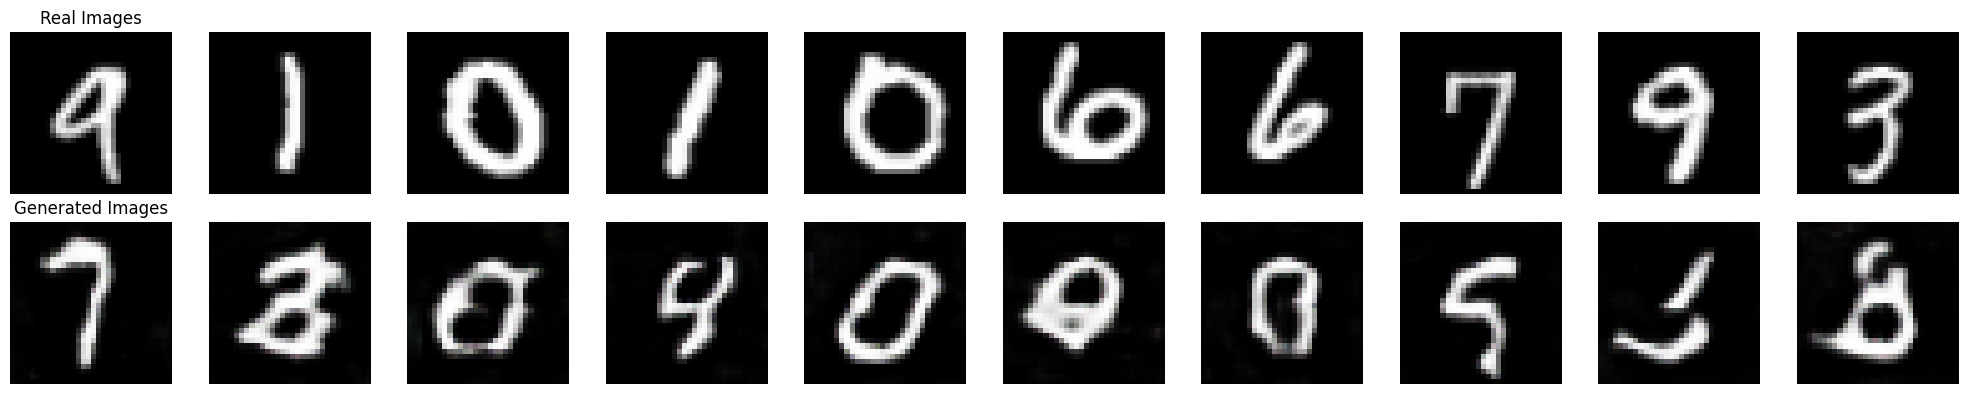

[Epoch 11/30] Loss D: -0.0692, Loss G: 0.0450 , FID score : 54.0920 , IS score : 2.2539
[Epoch 12/30] Loss D: -0.0679, Loss G: 0.0446 , FID score : 52.6654 , IS score : 2.2528
[Epoch 13/30] Loss D: -0.0669, Loss G: 0.0440 , FID score : 49.6857 , IS score : 2.2388
[Epoch 14/30] Loss D: -0.0659, Loss G: 0.0439 , FID score : 49.5777 , IS score : 2.2819
[Epoch 15/30] Loss D: -0.0648, Loss G: 0.0430 , FID score : 47.0270 , IS score : 2.2440
[Epoch 16/30] Loss D: -0.0640, Loss G: 0.0429 , FID score : 44.4927 , IS score : 2.3003
[Epoch 17/30] Loss D: -0.0631, Loss G: 0.0423 , FID score : 40.0767 , IS score : 2.3053
[Epoch 18/30] Loss D: -0.0623, Loss G: 0.0420 , FID score : 40.6776 , IS score : 2.2880
[Epoch 19/30] Loss D: -0.0614, Loss G: 0.0417 , FID score : 39.6545 , IS score : 2.2703
[Epoch 20/30] Loss D: -0.0606, Loss G: 0.0407 , FID score : 40.3529 , IS score : 2.3003


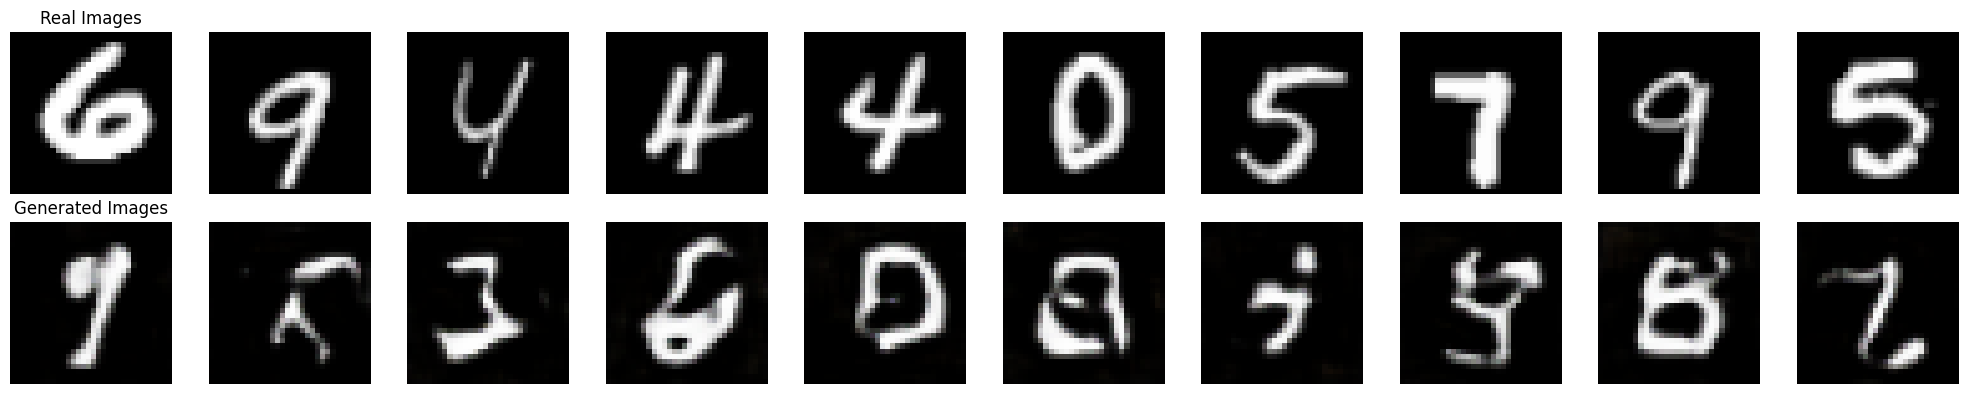

[Epoch 21/30] Loss D: -0.0598, Loss G: 0.0407 , FID score : 37.2004 , IS score : 2.2954
[Epoch 22/30] Loss D: -0.0593, Loss G: 0.0404 , FID score : 35.4821 , IS score : 2.2801
[Epoch 23/30] Loss D: -0.0587, Loss G: 0.0404 , FID score : 33.1026 , IS score : 2.2858
[Epoch 24/30] Loss D: -0.0581, Loss G: 0.0402 , FID score : 35.9717 , IS score : 2.2869
[Epoch 25/30] Loss D: -0.0574, Loss G: 0.0397 , FID score : 32.9852 , IS score : 2.2857
[Epoch 26/30] Loss D: -0.0566, Loss G: 0.0392 , FID score : 31.8345 , IS score : 2.3077
[Epoch 27/30] Loss D: -0.0563, Loss G: 0.0390 , FID score : 31.5135 , IS score : 2.2955
[Epoch 28/30] Loss D: -0.0556, Loss G: 0.0385 , FID score : 31.6628 , IS score : 2.2777
[Epoch 29/30] Loss D: -0.0553, Loss G: 0.0386 , FID score : 34.8919 , IS score : 2.2773
[Epoch 30/30] Loss D: -0.0546, Loss G: 0.0384 , FID score : 33.6140 , IS score : 2.2850


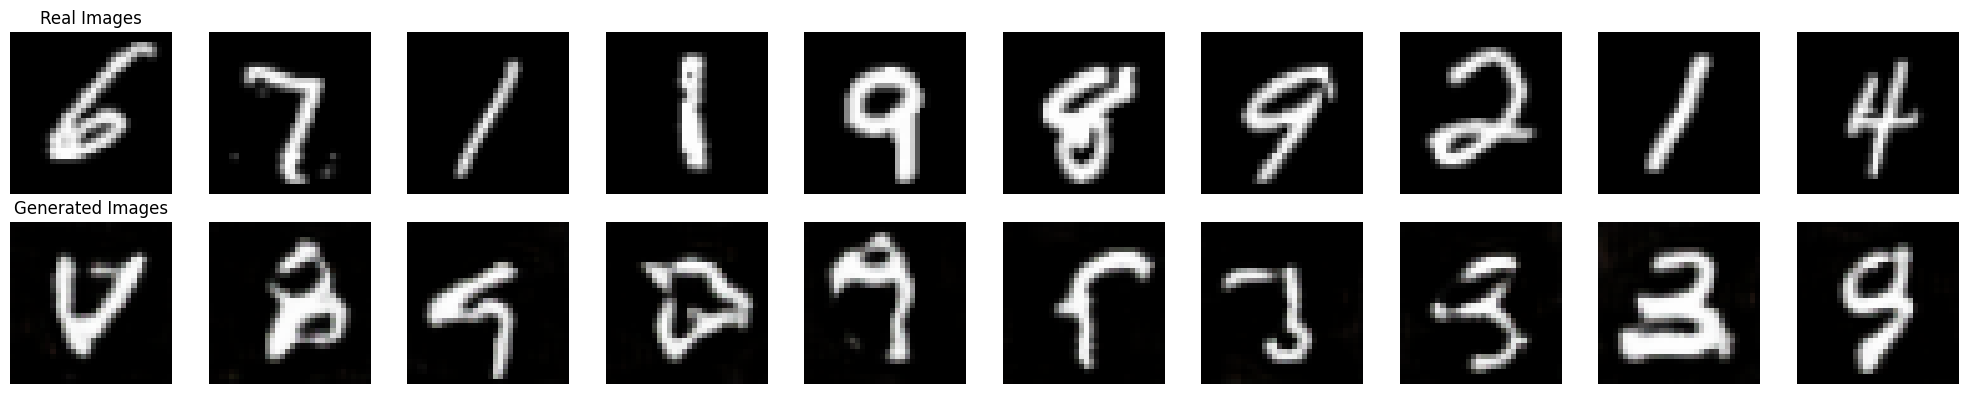

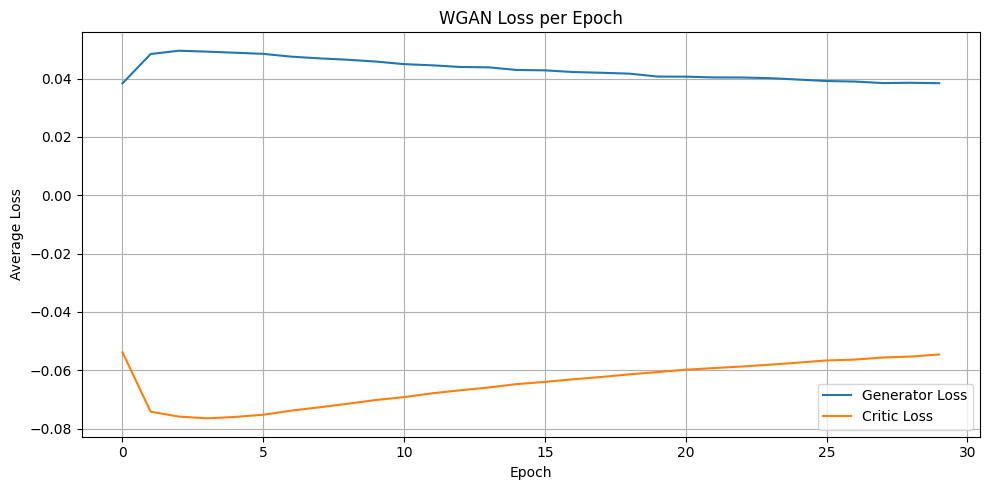

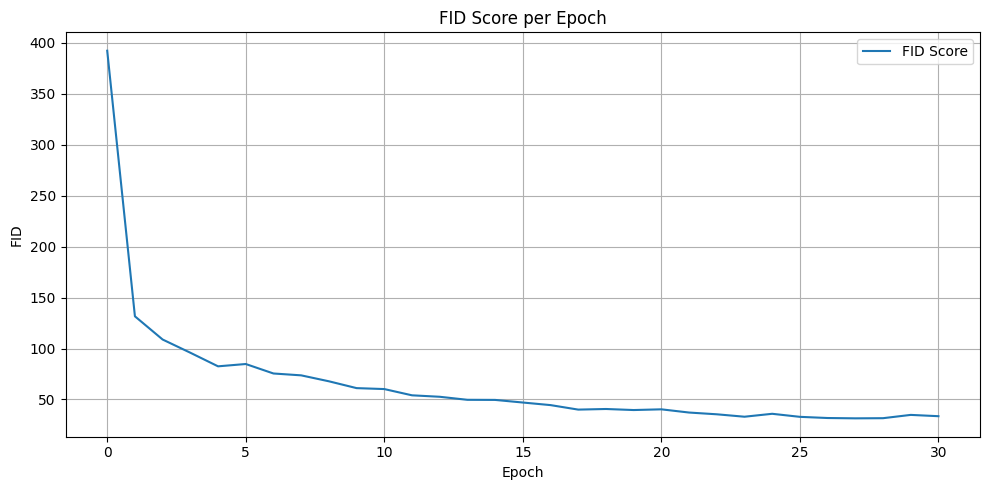

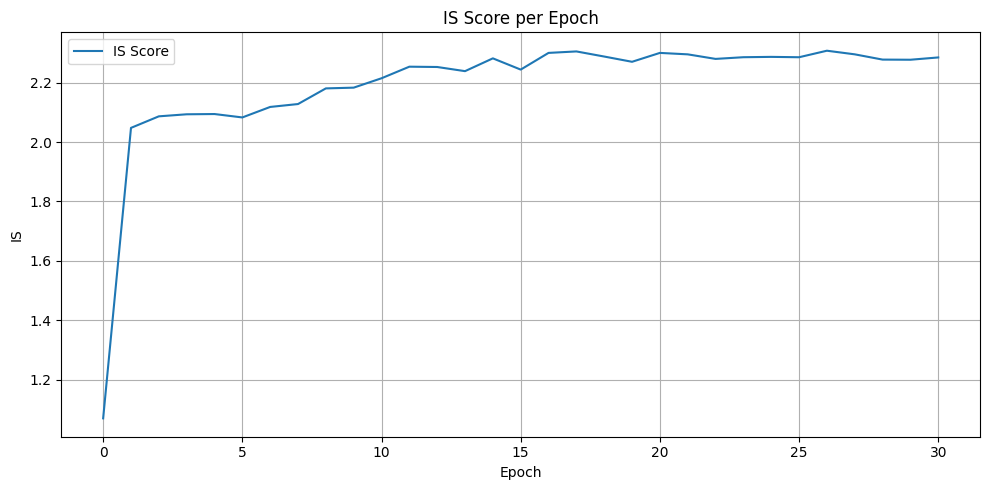

In [14]:
generator_1 = Generator(latent_dim).to(device)
critic_1 = Critic().to(device)
optimizer_g1 = optim.RMSprop(generator_1.parameters(), lr=lr)
optimizer_c1 = optim.RMSprop(critic_1.parameters(), lr=lr)

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_1(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
print("Before Training...")
val1 , val2 , _ = evaluate_metrics(generator_1, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val1} , IS : {val2}")
print("Training started...")

# Start training
fid_1 , is_1 = train_WGAN_CP(generator_1, critic_1, optimizer_g1, optimizer_c1, dataloader, device, latent_dim, n_critic , c , n_epochs , val1 , val2)

Before Training...


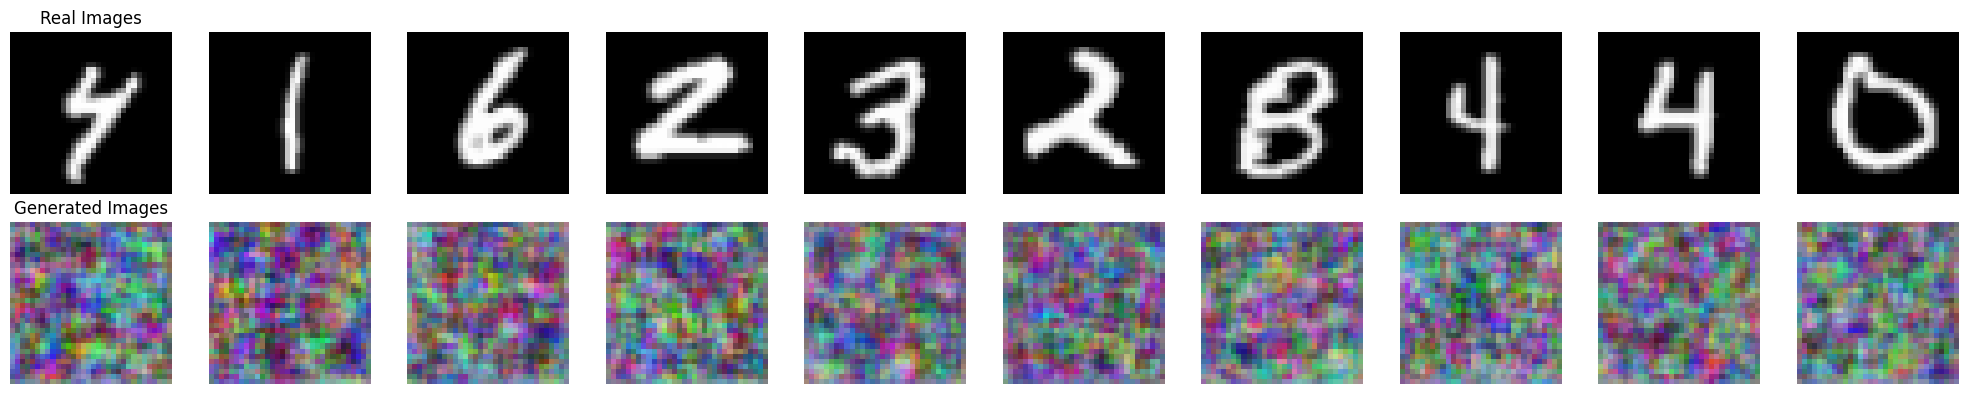

 FID : 381.16633595056896 , IS : 1.0952271223068237
Training started...
[Epoch 1/30] Loss D: -10.5432, Loss G: 7.2359 , FID score : 171.2243 , IS score : 2.2679
[Epoch 2/30] Loss D: -7.8882, Loss G: 10.1084 , FID score : 99.4155 , IS score : 2.2732
[Epoch 3/30] Loss D: -7.2415, Loss G: 13.6010 , FID score : 72.2386 , IS score : 2.2969
[Epoch 4/30] Loss D: -7.0472, Loss G: 15.5928 , FID score : 58.1174 , IS score : 2.2364
[Epoch 5/30] Loss D: -7.1830, Loss G: 17.6658 , FID score : 48.9050 , IS score : 2.3120
[Epoch 6/30] Loss D: -7.1882, Loss G: 19.1971 , FID score : 46.3466 , IS score : 2.3404
[Epoch 7/30] Loss D: -7.2214, Loss G: 20.8171 , FID score : 42.3107 , IS score : 2.3381
[Epoch 8/30] Loss D: -7.1769, Loss G: 22.2447 , FID score : 40.9566 , IS score : 2.3647
[Epoch 9/30] Loss D: -7.1009, Loss G: 23.0466 , FID score : 36.2172 , IS score : 2.3357
[Epoch 10/30] Loss D: -6.9604, Loss G: 23.3545 , FID score : 34.0906 , IS score : 2.3653


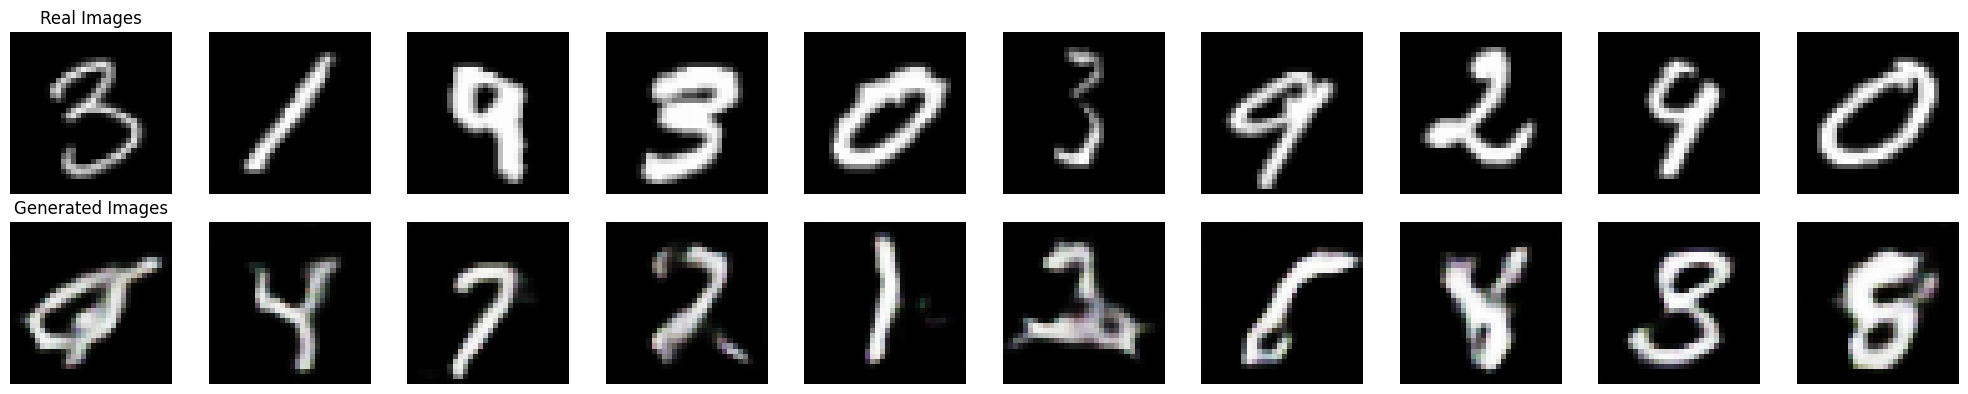

[Epoch 11/30] Loss D: -6.8745, Loss G: 24.5170 , FID score : 33.5229 , IS score : 2.3236
[Epoch 12/30] Loss D: -6.7730, Loss G: 25.1225 , FID score : 32.1433 , IS score : 2.2097
[Epoch 13/30] Loss D: -6.6621, Loss G: 26.3594 , FID score : 30.3184 , IS score : 2.3023
[Epoch 14/30] Loss D: -6.5289, Loss G: 27.0865 , FID score : 30.5758 , IS score : 2.3139
[Epoch 15/30] Loss D: -6.5569, Loss G: 27.7448 , FID score : 27.4624 , IS score : 2.3773
[Epoch 16/30] Loss D: -6.3643, Loss G: 28.2823 , FID score : 27.4401 , IS score : 2.3122
[Epoch 17/30] Loss D: -6.2445, Loss G: 28.9953 , FID score : 26.8702 , IS score : 2.3730
[Epoch 18/30] Loss D: -6.3313, Loss G: 29.8651 , FID score : 26.1432 , IS score : 2.3396
[Epoch 19/30] Loss D: -6.0166, Loss G: 30.1207 , FID score : 26.7507 , IS score : 2.3848
[Epoch 20/30] Loss D: -6.0751, Loss G: 30.8468 , FID score : 26.3542 , IS score : 2.3779


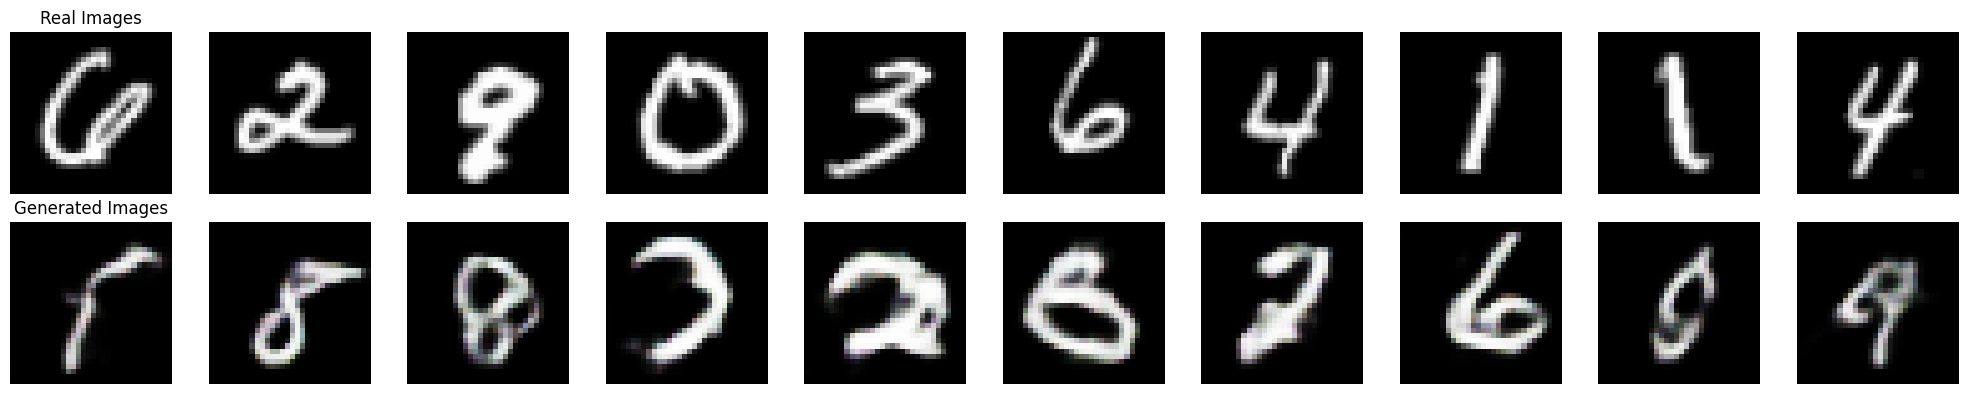

[Epoch 21/30] Loss D: -5.9695, Loss G: 31.3405 , FID score : 24.8196 , IS score : 2.3054
[Epoch 22/30] Loss D: -5.9050, Loss G: 31.7926 , FID score : 23.8617 , IS score : 2.2848
[Epoch 23/30] Loss D: -5.8224, Loss G: 32.2896 , FID score : 24.0519 , IS score : 2.4098
[Epoch 24/30] Loss D: -5.6706, Loss G: 32.9575 , FID score : 22.2389 , IS score : 2.3399
[Epoch 25/30] Loss D: -5.6079, Loss G: 33.5988 , FID score : 22.7181 , IS score : 2.3887
[Epoch 26/30] Loss D: -5.6185, Loss G: 33.6625 , FID score : 21.3241 , IS score : 2.3441
[Epoch 27/30] Loss D: -5.6032, Loss G: 33.7629 , FID score : 20.4232 , IS score : 2.3183
[Epoch 28/30] Loss D: -5.4161, Loss G: 34.6965 , FID score : 19.9484 , IS score : 2.3634
[Epoch 29/30] Loss D: -5.4419, Loss G: 34.8656 , FID score : 20.5840 , IS score : 2.2539
[Epoch 30/30] Loss D: -5.3003, Loss G: 35.4252 , FID score : 19.4632 , IS score : 2.3304


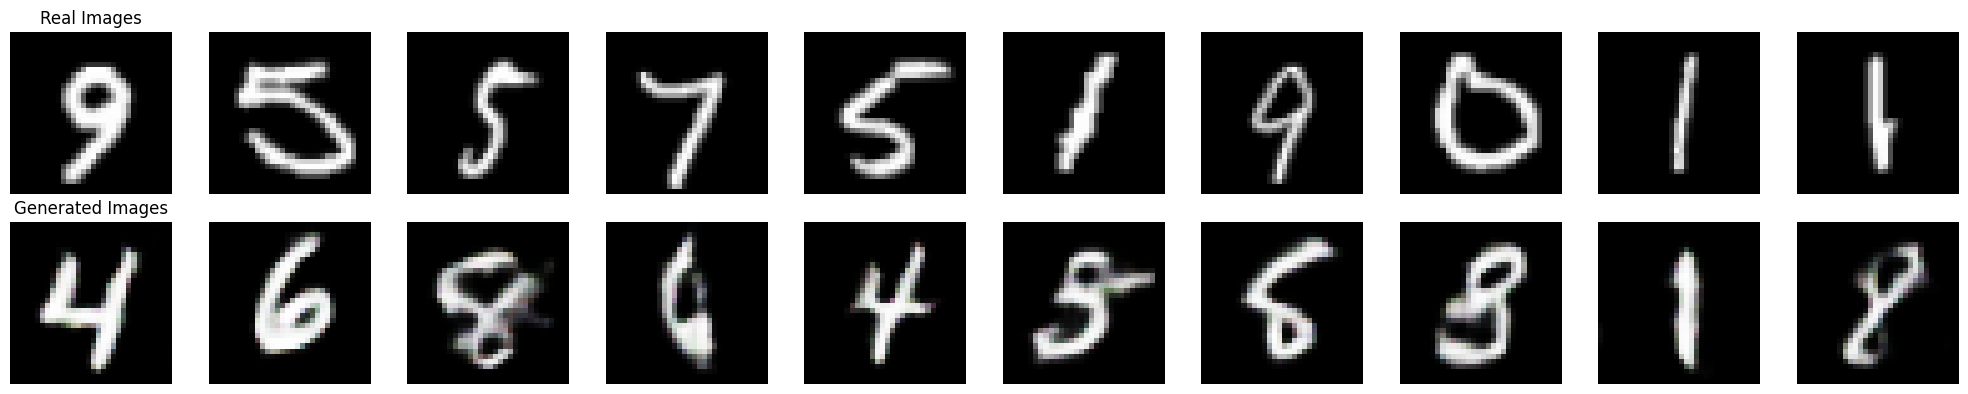

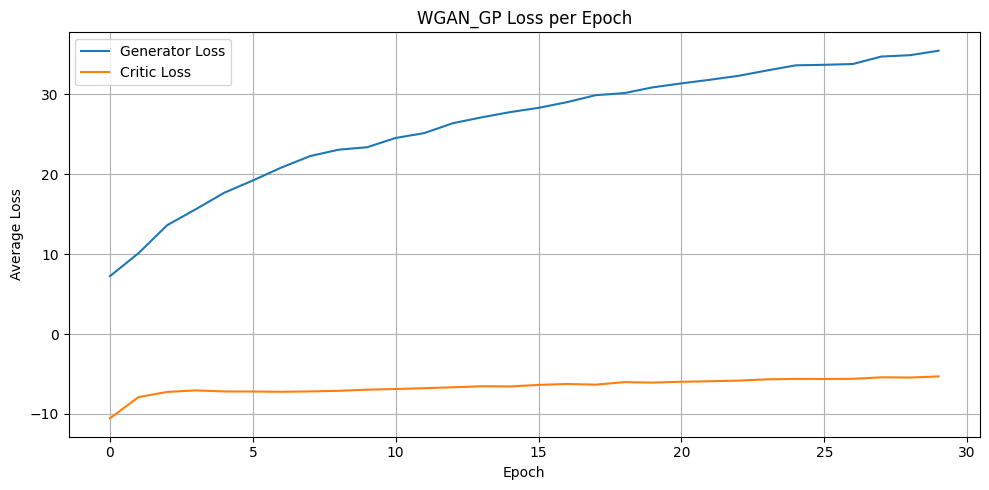

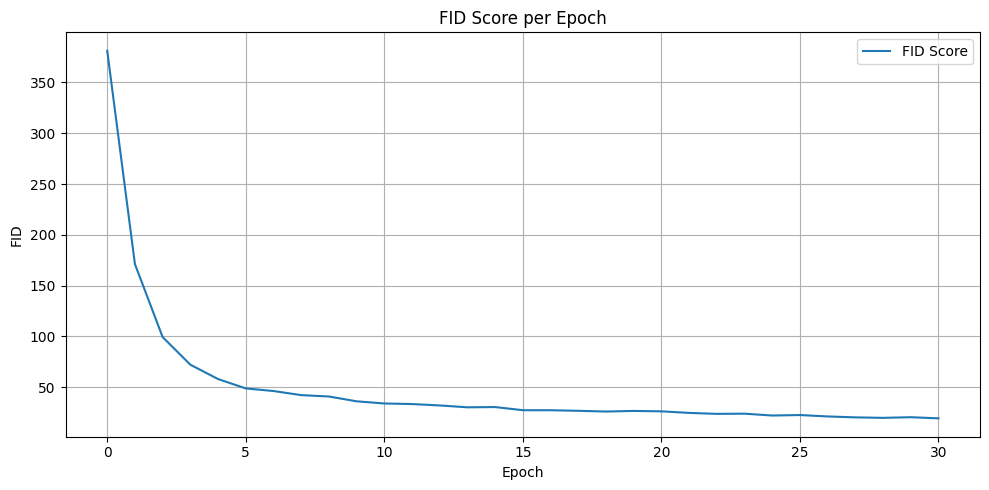

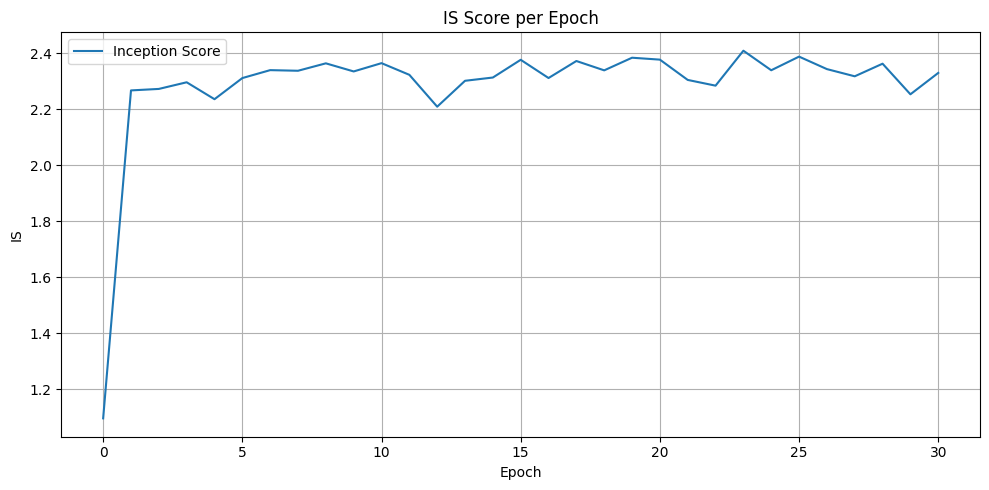

In [15]:
generator_2 = Generator(latent_dim).to(device)
critic_2 = Critic().to(device)
optimizer_g2 = optim.Adam(generator_2.parameters(), lr=lr,betas=(0.9, 0.999))
optimizer_c2 = optim.Adam(critic_2.parameters(), lr=lr,betas=(0.9, 0.999))

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_2(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
print("Before Training...")
val1 , val2 , _ = evaluate_metrics(generator_2, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val1} , IS : {val2}")
print("Training started...")

# Start training
fid_2 , is_2 = train_WGAN_GP(generator_2, critic_2, optimizer_g2, optimizer_c2, dataloader, device, latent_dim, n_critic , l , n_epochs , fid_0 = val1 , is_0 = val2)

Before Training...


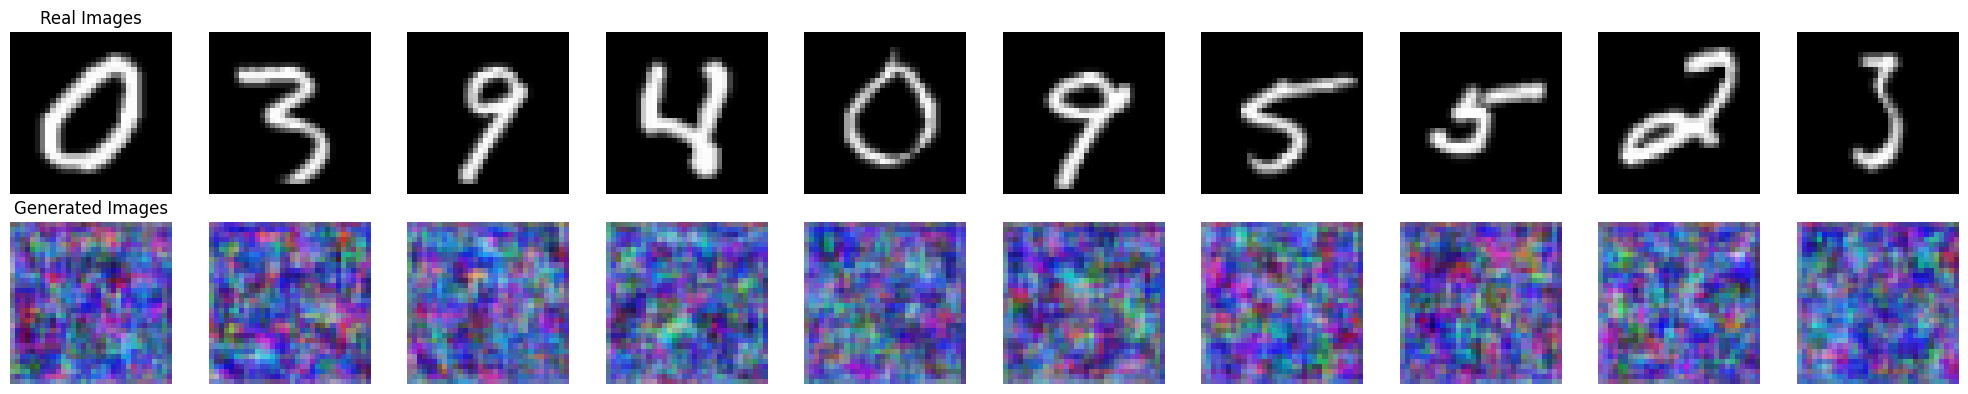

 FID : 373.9741823292867 , IS : 1.089590311050415
Training started...
[Epoch 1/30] Loss D: -69.4980, Loss G: 34.9682 , FID score : 148.4342 , IS score : 2.2578
[Epoch 2/30] Loss D: -192.5001, Loss G: 97.2761 , FID score : 94.4447 , IS score : 2.2919
[Epoch 3/30] Loss D: -351.1641, Loss G: 179.2981 , FID score : 70.7561 , IS score : 2.2323
[Epoch 4/30] Loss D: -548.6127, Loss G: 280.8735 , FID score : 63.5436 , IS score : 2.2440
[Epoch 5/30] Loss D: -781.0963, Loss G: 400.7662 , FID score : 58.7332 , IS score : 2.2556
[Epoch 6/30] Loss D: -1039.3006, Loss G: 534.1310 , FID score : 52.8233 , IS score : 2.2746
[Epoch 7/30] Loss D: -1320.9650, Loss G: 678.3864 , FID score : 53.9166 , IS score : 2.3070
[Epoch 8/30] Loss D: -1624.9319, Loss G: 835.3662 , FID score : 52.2562 , IS score : 2.3195
[Epoch 9/30] Loss D: -1952.7796, Loss G: 1000.7731 , FID score : 51.3897 , IS score : 2.3448
[Epoch 10/30] Loss D: -2303.7744, Loss G: 1184.4193 , FID score : 49.9106 , IS score : 2.3447


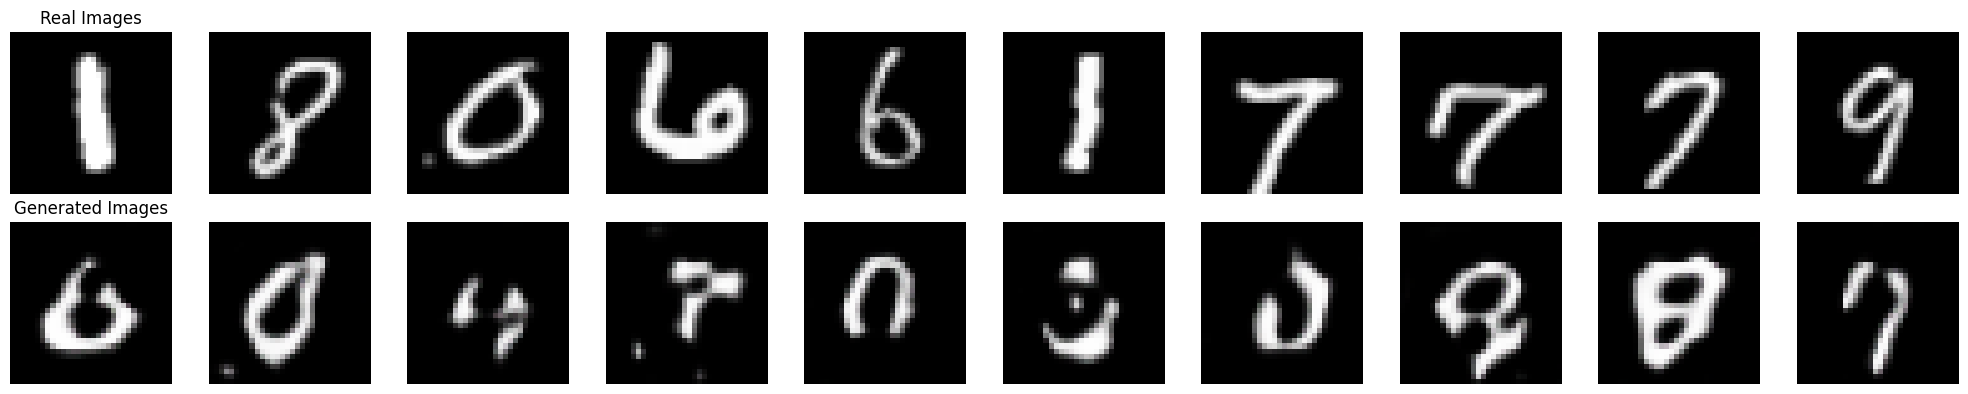

[Epoch 11/30] Loss D: -2684.2287, Loss G: 1378.0524 , FID score : 50.5619 , IS score : 2.3592
[Epoch 12/30] Loss D: -3093.8162, Loss G: 1589.4375 , FID score : 49.1819 , IS score : 2.3828
[Epoch 13/30] Loss D: -3531.5127, Loss G: 1818.7409 , FID score : 48.7530 , IS score : 2.3668
[Epoch 14/30] Loss D: -3998.5923, Loss G: 2055.1232 , FID score : 49.7144 , IS score : 2.3872
[Epoch 15/30] Loss D: -4488.6991, Loss G: 2310.7092 , FID score : 48.3347 , IS score : 2.3647
[Epoch 16/30] Loss D: -5005.3557, Loss G: 2574.6300 , FID score : 48.6194 , IS score : 2.3861
[Epoch 17/30] Loss D: -5552.5569, Loss G: 2862.4159 , FID score : 48.0080 , IS score : 2.4132
[Epoch 18/30] Loss D: -6123.4609, Loss G: 3155.8432 , FID score : 49.7545 , IS score : 2.3892
[Epoch 19/30] Loss D: -6722.3826, Loss G: 3464.7980 , FID score : 47.1555 , IS score : 2.3775
[Epoch 20/30] Loss D: -7343.7255, Loss G: 3785.9259 , FID score : 50.2403 , IS score : 2.3763


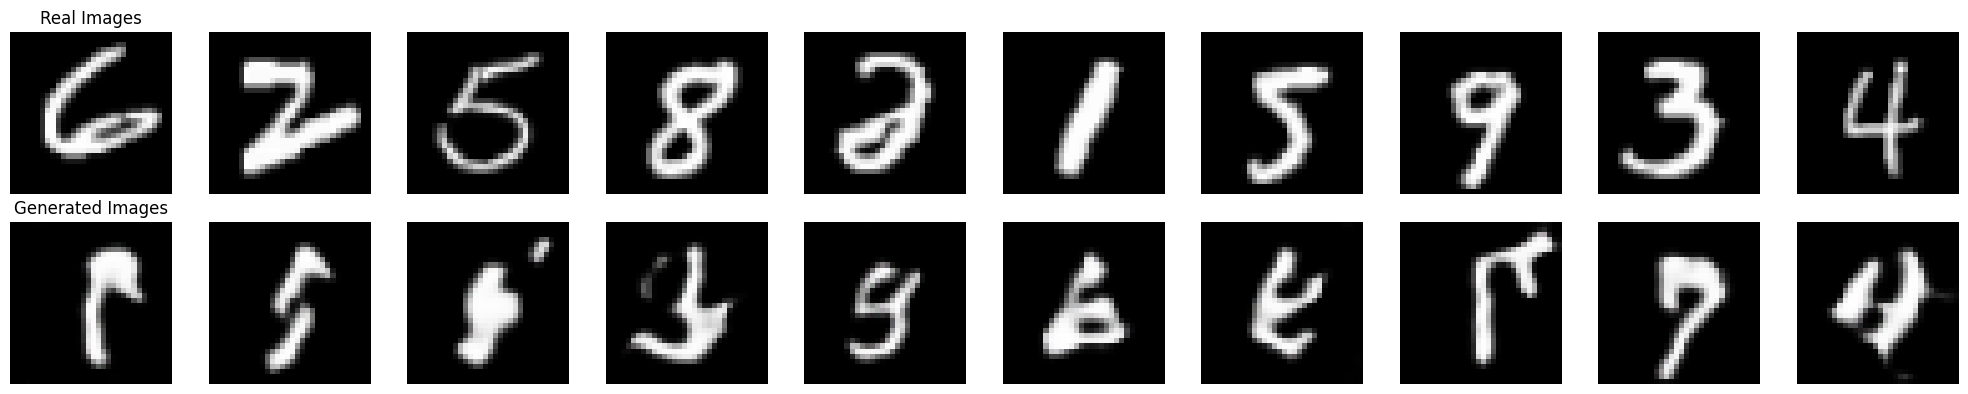

[Epoch 21/30] Loss D: -7995.4761, Loss G: 4119.4018 , FID score : 48.2202 , IS score : 2.3947
[Epoch 22/30] Loss D: -8676.4647, Loss G: 4468.9174 , FID score : 48.2930 , IS score : 2.3759
[Epoch 23/30] Loss D: -9379.2230, Loss G: 4833.8886 , FID score : 48.8020 , IS score : 2.3718
[Epoch 24/30] Loss D: -10113.5994, Loss G: 5214.2931 , FID score : 47.3933 , IS score : 2.3883
[Epoch 25/30] Loss D: -10871.4969, Loss G: 5600.9149 , FID score : 49.2062 , IS score : 2.3956
[Epoch 26/30] Loss D: -11650.7582, Loss G: 6018.0142 , FID score : 47.4943 , IS score : 2.3768
[Epoch 27/30] Loss D: -12459.1652, Loss G: 6427.1623 , FID score : 48.5131 , IS score : 2.3784
[Epoch 28/30] Loss D: -13290.9095, Loss G: 6854.5607 , FID score : 48.1660 , IS score : 2.3753
[Epoch 29/30] Loss D: -14148.5369, Loss G: 7295.3671 , FID score : 49.1795 , IS score : 2.3861
[Epoch 30/30] Loss D: -15030.5999, Loss G: 7749.5940 , FID score : 48.5336 , IS score : 2.3923


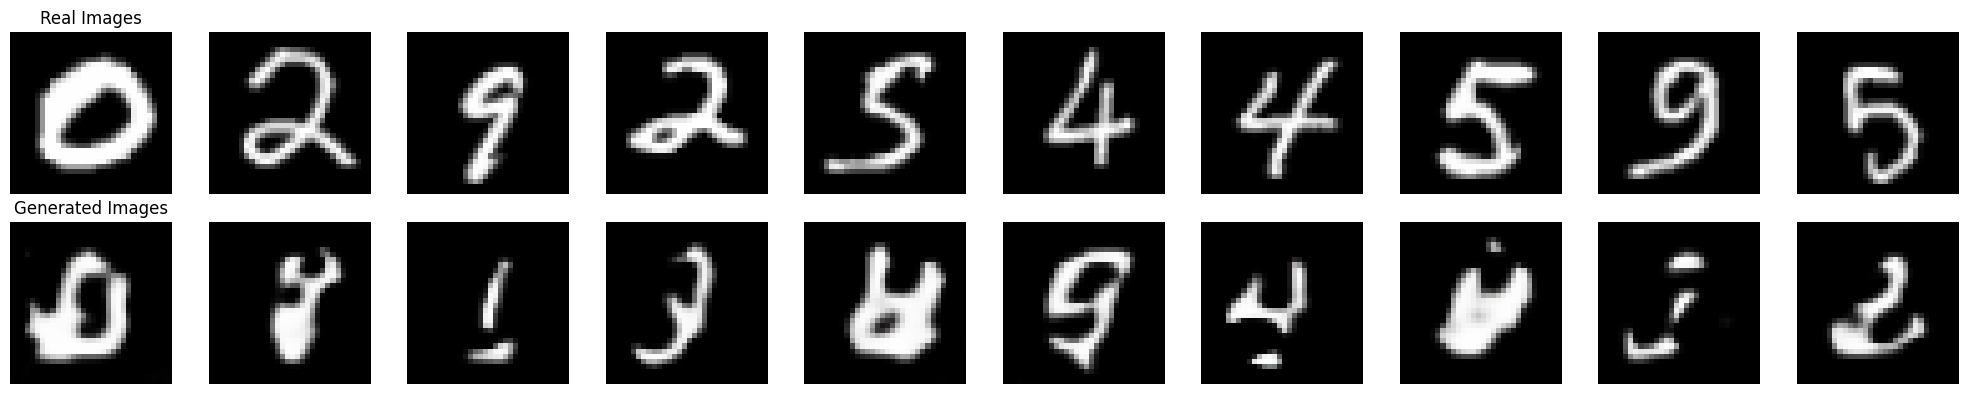

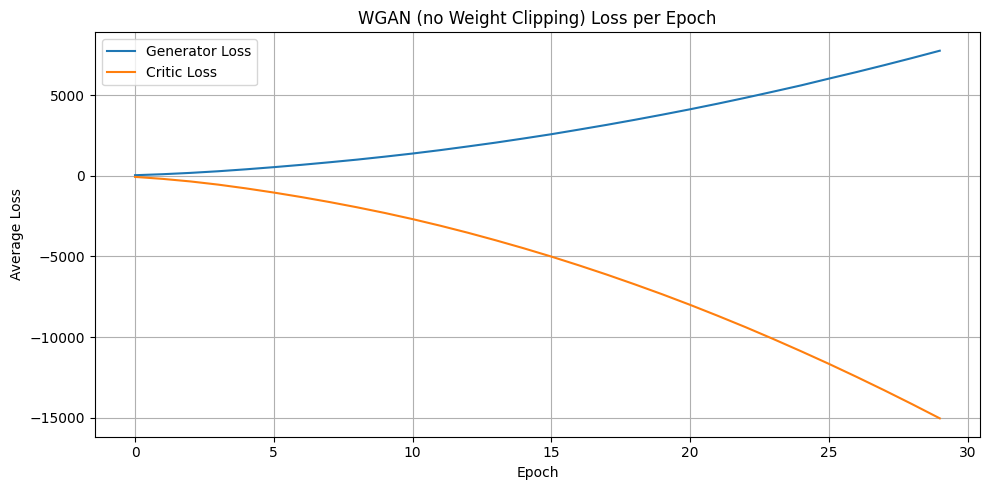

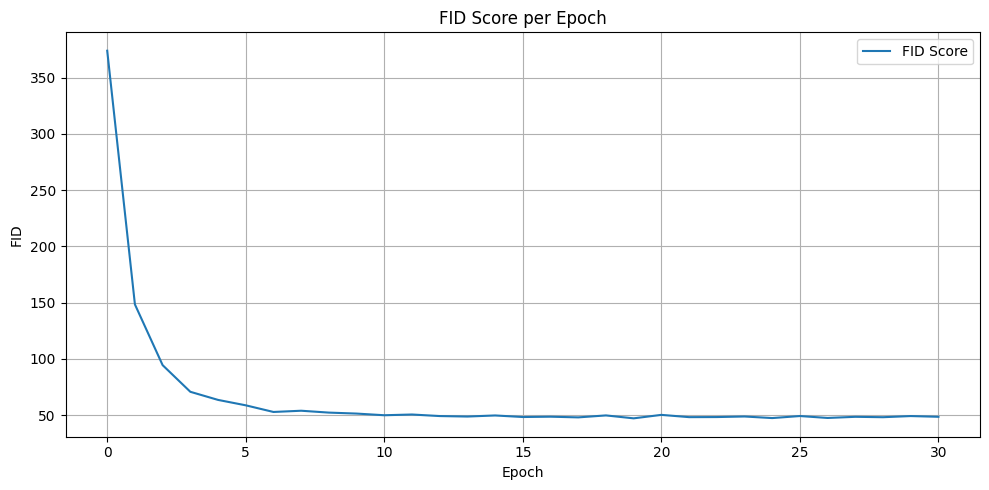

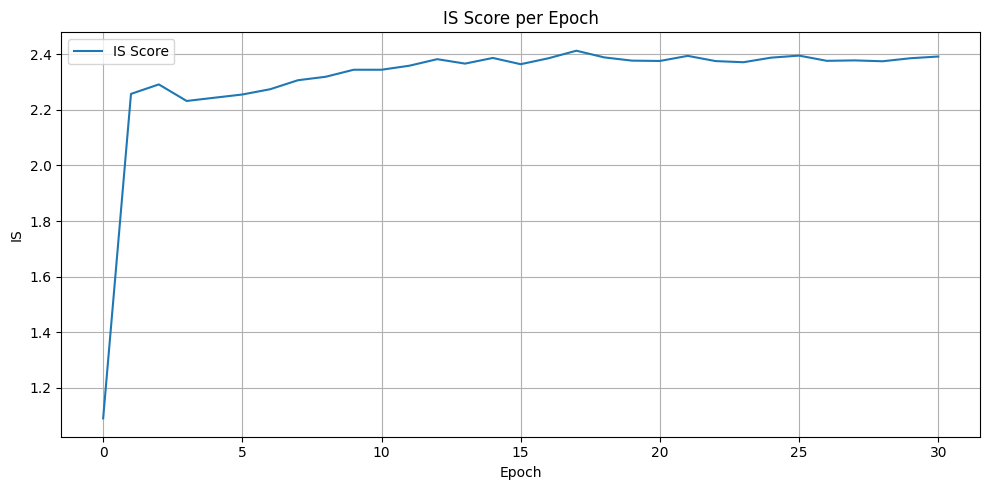

In [16]:
generator_3 = Generator(latent_dim).to(device)
critic_3 = Critic().to(device)
optimizer_g3 = optim.Adam(generator_3.parameters(), lr=lr,betas=(0.9, 0.999))
optimizer_c3 = optim.Adam(critic_3.parameters(), lr=lr,betas=(0.9, 0.999))

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_3(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
print("Before Training...")
val1 , val2 , _ = evaluate_metrics(generator_3, dataloader, 15000 , 1000 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val1} , IS : {val2}")
print("Training started...")

# Start training
fid_3 , is_3 = train_WGAN(generator_3, critic_3, optimizer_g3, optimizer_c3, dataloader, device, latent_dim, n_critic , n_epochs , fid_0 = val1 , is_0 = val2)

Before Training...


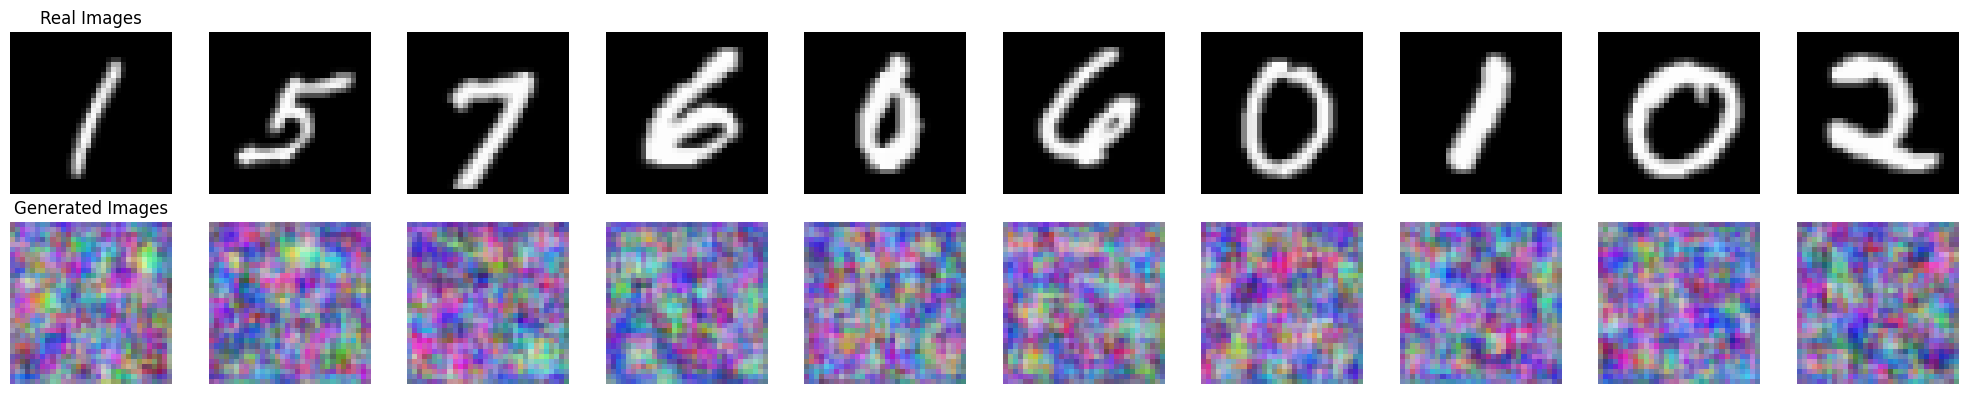

 FID : 366.58666545214345 , IS : 1.088897943496704
Training started...
[Epoch 1/30] Loss D: 0.8666, Loss G: 1.4898 , FID score : 202.1420 , Inception score : 2.0943
[Epoch 2/30] Loss D: 0.9437, Loss G: 1.3012 , FID score : 125.5648 , Inception score : 2.3504
[Epoch 3/30] Loss D: 0.9222, Loss G: 1.3251 , FID score : 89.5005 , Inception score : 2.3163
[Epoch 4/30] Loss D: 0.9277, Loss G: 1.3345 , FID score : 66.5386 , Inception score : 2.2890
[Epoch 5/30] Loss D: 0.9226, Loss G: 1.3726 , FID score : 54.5559 , Inception score : 2.2414
[Epoch 6/30] Loss D: 0.9071, Loss G: 1.4062 , FID score : 47.9790 , Inception score : 2.2270
[Epoch 7/30] Loss D: 0.8796, Loss G: 1.4558 , FID score : 42.3325 , Inception score : 2.2086
[Epoch 8/30] Loss D: 0.8478, Loss G: 1.5330 , FID score : 42.6442 , Inception score : 2.1952
[Epoch 9/30] Loss D: 0.8190, Loss G: 1.5950 , FID score : 46.3071 , Inception score : 2.1784
[Epoch 10/30] Loss D: 0.7990, Loss G: 1.6544 , FID score : 41.8886 , Inception score : 2.2

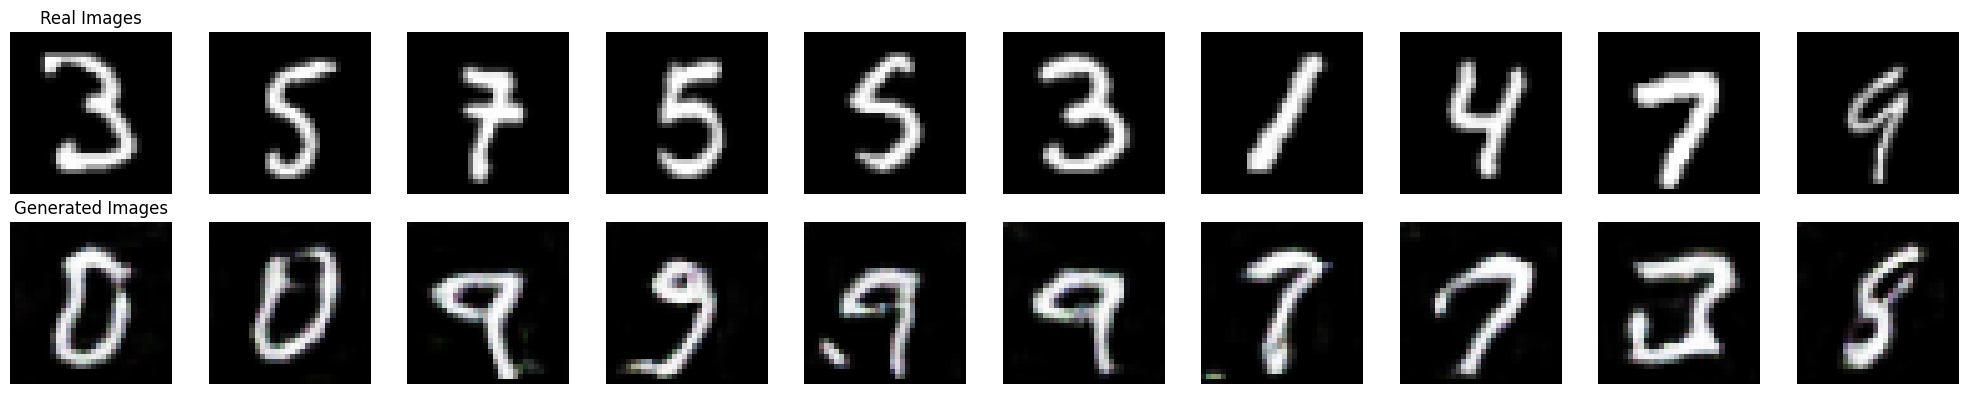

[Epoch 11/30] Loss D: 0.7781, Loss G: 1.7113 , FID score : 42.4046 , Inception score : 2.2380
[Epoch 12/30] Loss D: 0.7540, Loss G: 1.7701 , FID score : 36.8039 , Inception score : 2.2267
[Epoch 13/30] Loss D: 0.7355, Loss G: 1.8274 , FID score : 39.5092 , Inception score : 2.1578
[Epoch 14/30] Loss D: 0.7172, Loss G: 1.8933 , FID score : 36.9465 , Inception score : 2.2416
[Epoch 15/30] Loss D: 0.6911, Loss G: 1.9642 , FID score : 36.6201 , Inception score : 2.2513
[Epoch 16/30] Loss D: 0.6858, Loss G: 2.0393 , FID score : 33.3260 , Inception score : 2.2547
[Epoch 17/30] Loss D: 0.6391, Loss G: 2.1090 , FID score : 33.8756 , Inception score : 2.2068
[Epoch 18/30] Loss D: 0.6292, Loss G: 2.1813 , FID score : 29.3936 , Inception score : 2.2424
[Epoch 19/30] Loss D: 0.5959, Loss G: 2.2827 , FID score : 33.7866 , Inception score : 2.2012
[Epoch 20/30] Loss D: 0.5839, Loss G: 2.3365 , FID score : 33.0428 , Inception score : 2.2049


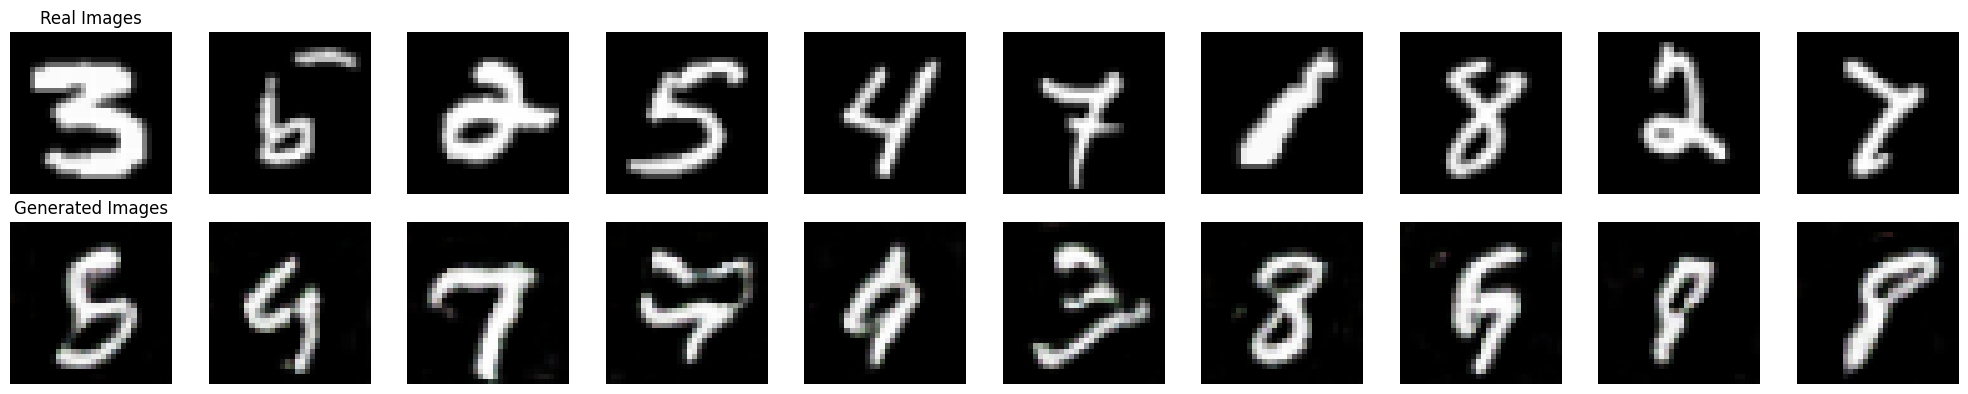

[Epoch 21/30] Loss D: 0.5627, Loss G: 2.4441 , FID score : 30.9094 , Inception score : 2.2056
[Epoch 22/30] Loss D: 0.5189, Loss G: 2.5365 , FID score : 31.8185 , Inception score : 2.2569
[Epoch 23/30] Loss D: 0.5068, Loss G: 2.6091 , FID score : 32.1201 , Inception score : 2.2338
[Epoch 24/30] Loss D: 0.4909, Loss G: 2.7239 , FID score : 31.3616 , Inception score : 2.2760
[Epoch 25/30] Loss D: 0.4948, Loss G: 2.7508 , FID score : 31.7665 , Inception score : 2.2951
[Epoch 26/30] Loss D: 0.4377, Loss G: 2.8837 , FID score : 30.1585 , Inception score : 2.2609
[Epoch 27/30] Loss D: 0.4347, Loss G: 2.9863 , FID score : 29.6035 , Inception score : 2.2371
[Epoch 28/30] Loss D: 0.4193, Loss G: 3.0673 , FID score : 33.6502 , Inception score : 2.2820
[Epoch 29/30] Loss D: 0.4322, Loss G: 3.0711 , FID score : 30.9744 , Inception score : 2.2728
[Epoch 30/30] Loss D: 0.4020, Loss G: 3.2103 , FID score : 32.0268 , Inception score : 2.2423


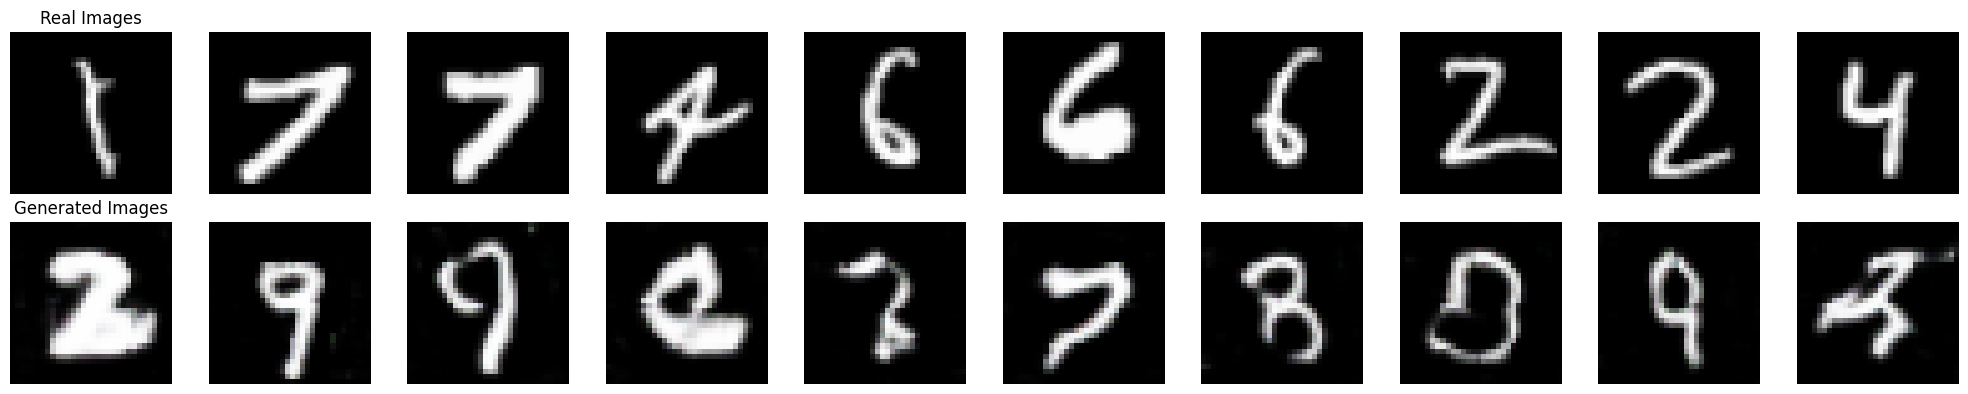

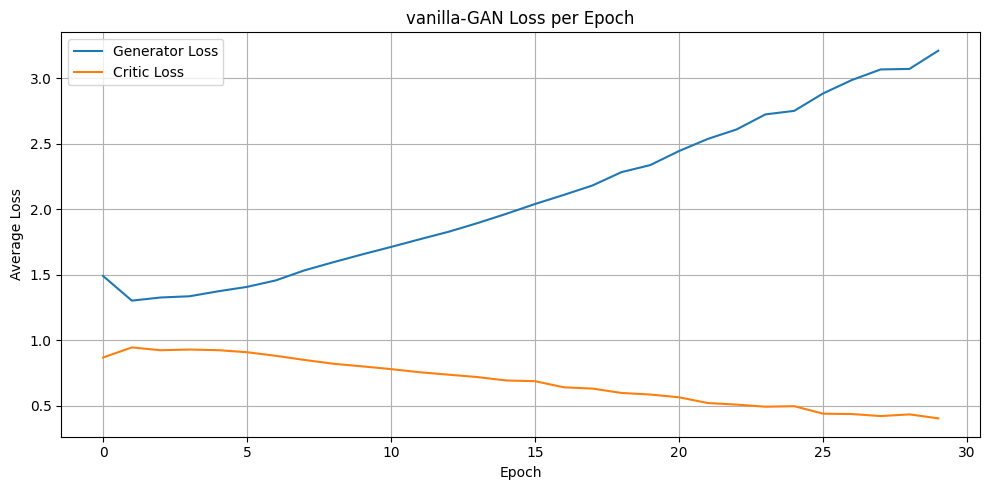

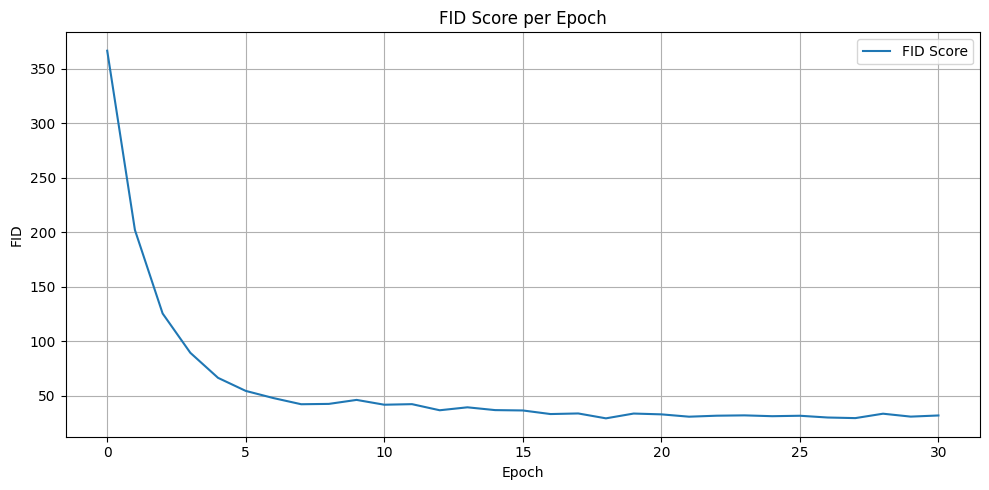

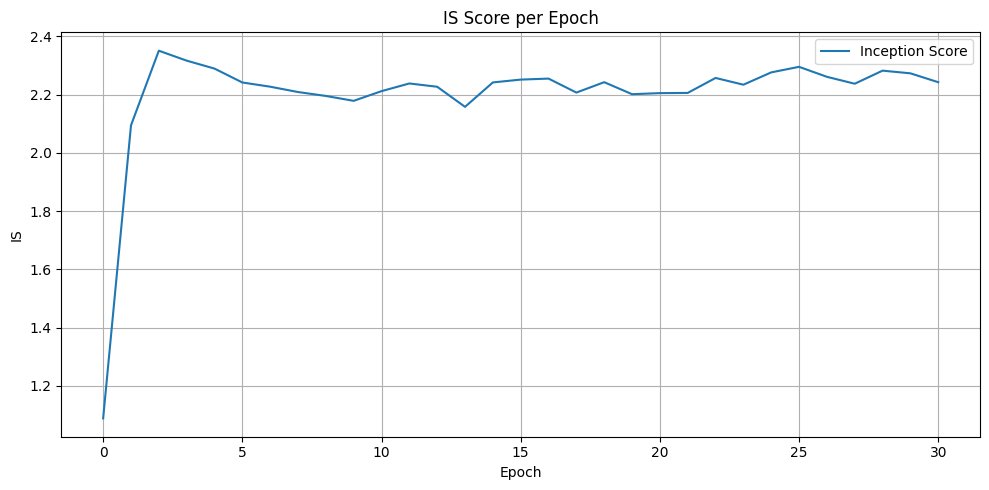

In [21]:
generator_4 = Generator(latent_dim).to(device)
critic_4 = Critic().to(device)
optimizer_g4 = optim.Adam(generator_4.parameters(), lr=lr,betas=(0.0, 0.999))
optimizer_c4 = optim.Adam(critic_4.parameters(), lr=lr,betas=(0.0, 0.999))

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_4(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
print("Before Training...")
val1 , val2 , _ = evaluate_metrics(generator_4, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val1} , IS : {val2}")
print("Training started...")

# Start training
fid_4 , is_4 = train_vanillaGAN(generator_4, critic_4, optimizer_g4, optimizer_c4, dataloader, device, latent_dim, n_epochs , fid_0 = val1 , is_0 = val2)

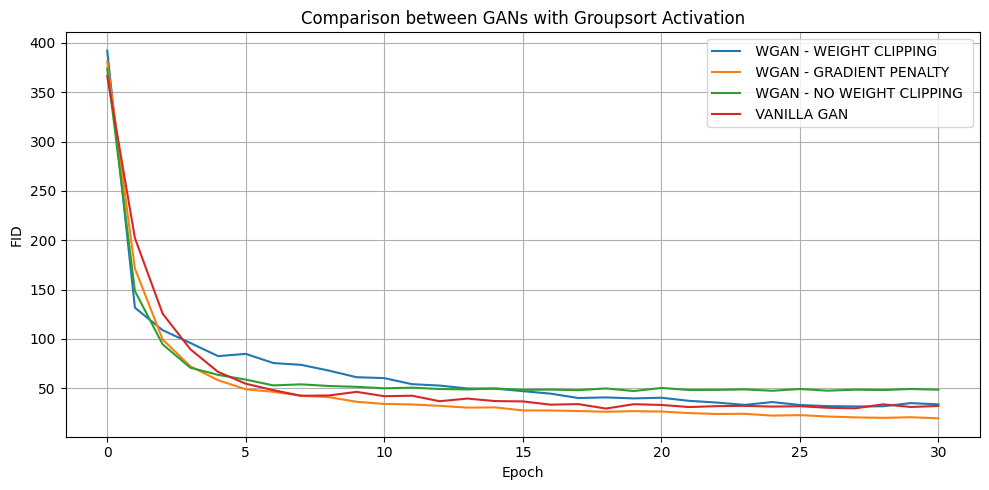

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(fid_1 ,label=' WGAN - WEIGHT CLIPPING')
plt.plot(fid_2 ,label=' WGAN - GRADIENT PENALTY')
plt.plot(fid_3 ,label=' WGAN - NO WEIGHT CLIPPING ')
plt.plot(fid_4 ,label=' VANILLA GAN')
plt.plot
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("Comparison between GANs with Groupsort Activation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

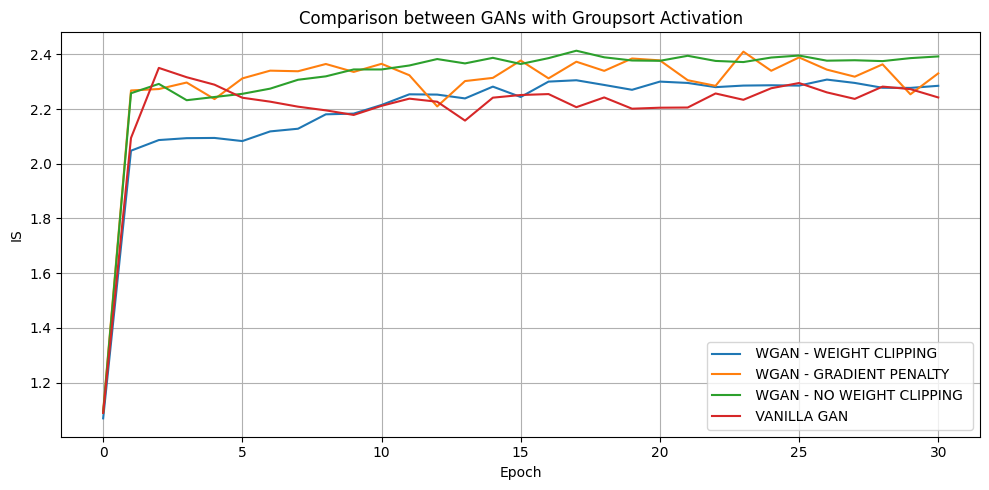

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(is_1 ,label=' WGAN - WEIGHT CLIPPING')
plt.plot(is_2 ,label=' WGAN - GRADIENT PENALTY')
plt.plot(is_3 ,label=' WGAN - NO WEIGHT CLIPPING ')
plt.plot(is_4 ,label=' VANILLA GAN')
plt.plot
plt.xlabel("Epoch")
plt.ylabel("IS")
plt.title("Comparison between GANs with Groupsort Activation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()